In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Define seed
SEED = 42

# Set the seed for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU setups
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
torch.backends.cudnn.benchmark = False    # Disable if you want deterministic results

In [45]:
# Define MLP
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
           nn.Linear(input_dim, 512),
           nn.ReLU(True),
           nn.Linear(512, 256),
           nn.ReLU(True),
           nn.Linear(256, 128),
           nn.ReLU(True),
           nn.Linear(128, 64),
           nn.ReLU(True),
           nn.Linear(64, 32),
           nn.ReLU(True),
           nn.Linear(32, 16),
           nn.ReLU(True),
           nn.Linear(16, 1),
           nn.Sigmoid()  # Normalize output to [0, 1]
        )
    def forward(self, x):
        x = self.mlp(x)
        return x

In [46]:
def get_datasets(dataset):

    atributos_comuns = ['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS', 'TCP_FLAGS', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'DURATION_IN', 'DURATION_OUT', 'MIN_TTL', 'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES', 'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS', 'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS', 'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT', 'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES', 'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES', 'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT', 'ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE', 'DNS_TTL_ANSWER', 'FTP_COMMAND_RET_CODE', 'Label', 'Attack']
    
    if dataset == "dataset1":
         df = pd.read_csv('datasets/dataset1v2.csv') # NF-BoT-IoT-v2
    if dataset == "dataset2":
         df = pd.read_csv('datasets/dataset2v2.csv') # NF-ToN-IoT-v2
    if dataset == "dataset3":
         df = pd.read_csv('datasets/dataset3v2.csv') # NF-UNSW-NB15-v2
    if dataset == "dataset4":
         df = pd.read_csv('datasets/dataset4v2.csv') # NF-CICIDS2018-v3
    if dataset == "datasets1_4":
         df = pd.read_csv('datasets/datasets1_4.csv') # Todos 25% de cada - balanceado
    dataframe = df[atributos_comuns]
    
    return dataframe

In [47]:
def preprocessing_data(df):
    df_source = df
    df_source_label = df_source['Label']
    df_source = df_source.drop('IPV4_SRC_ADDR',axis=1)
    df_source = df_source.drop('IPV4_DST_ADDR',axis=1)
    df_source = df_source.drop('Attack',axis=1)
    df_source = df_source.drop('Label',axis=1)
    
    # normalize
    df_z = (df_source - df_source.mean()) / df_source.std().replace(0, 1)
    df_source = (df_z - df_z.min()) / (df_z.max() - df_z.min()).replace(0, 1)
    
    df_source_label = df_source_label.to_frame()
    x_source1_train, x_source1_test, y_source1_train, y_source1_test = train_test_split(df_source, df_source_label, test_size = 0.20)
    return df_source, df_source_label, x_source1_train, x_source1_test, y_source1_train, y_source1_test

In [48]:
def tensor_data(x_train, y_train):
    previsores_train = torch.tensor(np.array(x_train), dtype = torch.float)
    class_train = torch.tensor(np.array(y_train, dtype=np.float32), dtype = torch.float)
    dataset = torch.utils.data.TensorDataset(previsores_train, class_train)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=41, shuffle=True)
    return previsores_train, class_train, dataset, train_loader

In [49]:
def inicia_datasets(treino):
      df = get_datasets(treino)
      print(f"Prepara {treino}: {df.shape}")
      df, y_label, x_train, x_test, y_train, y_test = preprocessing_data(df)
      print( x_train.shape, y_train.shape)
      print( x_test.shape, y_test.shape)
      dataset_train, class_train, dataset_train, loader_train = tensor_data( x_train,  y_train)
      dataset_test, class_test, dataset_test, loader_test = tensor_data( x_test,  y_test)
      return loader_train, loader_test, dataset_train, dataset_test, class_train, class_test

In [50]:
treino = "dataset1" # dataset1, dataset2, dataset3, dataset4, dataset1_4 
loader_train, source_val, dataset_train, dataset_train2, class_train, class_val = inicia_datasets(treino)

Prepara dataset1: (224511, 45)
(179608, 41) (179608, 1)
(44903, 41) (44903, 1)


In [51]:
def treina_modelo(input_dim, modelo_MLP, loader_train, device):

    from sklearn.metrics import classification_report

    # Hiperparâmetros
    num_classes = 2
    epochs = 30
    lr = 0.001

    # Otimizador conjunto
    params = list(modelo_MLP.parameters())
    optimizer = torch.optim.Adam(params, lr=lr)

    # Histórico
    loss_vals = []
    loss_valsMLP = []
    val_accuracies = []

    for epoch in range(epochs):

        modelo_MLP.train()
        epoch_loss_class = []
        epoch_loss_val = []

        for X, y in loader_train:
            X = X.to(device)
            y = y.to(device).float()
            y = y.view(-1, 1)
            
            optimizer.zero_grad()
                                    
            # Classificação com vetor latente
            outputs = modelo_MLP(X)

            # Perda de classificação
            loss_class = F.binary_cross_entropy(outputs, y)
            epoch_loss_class.append(loss_class.item())
            loss_class.backward()
            optimizer.step()
            
        # === Logs da época ===
        loss_epoch_class = sum(epoch_loss_class) / len(epoch_loss_class)
        loss_vals.append(loss_epoch_class)
        loss_valsMLP.append(loss_epoch_class)
        
        print(f"Epoch {epoch+1:02d}/{epochs} | Class: {loss_epoch_class:.4f}")

        modelo_MLP.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
           for X_val, y_val in source_val:
               X_val, y_val = X_val.to(device), y_val.to(device).float().view(-1, 1)
               out = modelo_MLP(X_val)
               # Calcula loss (BCE para binário)
               loss_class = F.binary_cross_entropy(out, y_val)
               epoch_loss_val.append(loss_class.item())
               preds = (out > 0.5).float()
               all_preds.append(preds.cpu())
               all_labels.append(y_val.cpu())

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        acc = (all_preds.view(-1) == all_labels.view(-1)).float().mean().item()
        val_accuracies.append(acc)
        print(f"Acurácia: {acc}")
        loss_epoch_val = sum(epoch_loss_val) / len(epoch_loss_val)

    # === Plots ===
    plt.plot(range(1, epochs + 1), loss_valsMLP, label='MLP')
    plt.title('Treinamento - Perdas - Source')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # === Plots ===
    plt.plot(range(1, epochs + 1), loss_vals, label='MLP')
    plt.title('Validação - Perdas - Source')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Acurácia
    plt.subplot(1,2,2)
    plt.plot(val_accuracies, label='Validação', color='green')
    plt.title('Acurácia de Validação por Época')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(classification_report(all_labels, all_preds, digits=4, zero_division=0))
    return all_preds, all_labels

Epoch 01/30 | Class: 0.0324
Acurácia: 0.9959691166877747
Epoch 02/30 | Class: 0.0114
Acurácia: 0.9971048831939697
Epoch 03/30 | Class: 0.0094
Acurácia: 0.9968599081039429
Epoch 04/30 | Class: 0.0077
Acurácia: 0.9974166750907898
Epoch 05/30 | Class: 0.0074
Acurácia: 0.9979956746101379
Epoch 06/30 | Class: 0.0070
Acurácia: 0.9976838827133179
Epoch 07/30 | Class: 0.0064
Acurácia: 0.9975502490997314
Epoch 08/30 | Class: 0.0065
Acurácia: 0.9978175163269043
Epoch 09/30 | Class: 0.0062
Acurácia: 0.9980624914169312
Epoch 10/30 | Class: 0.0060
Acurácia: 0.9982183575630188
Epoch 11/30 | Class: 0.0058
Acurácia: 0.9982629418373108
Epoch 12/30 | Class: 0.0056
Acurácia: 0.9982183575630188
Epoch 13/30 | Class: 0.0057
Acurácia: 0.998307466506958
Epoch 14/30 | Class: 0.0055
Acurácia: 0.9981070160865784
Epoch 15/30 | Class: 0.0055
Acurácia: 0.9981293082237244
Epoch 16/30 | Class: 0.0053
Acurácia: 0.9983742833137512
Epoch 17/30 | Class: 0.0053
Acurácia: 0.9979956746101379
Epoch 18/30 | Class: 0.0065
Acur

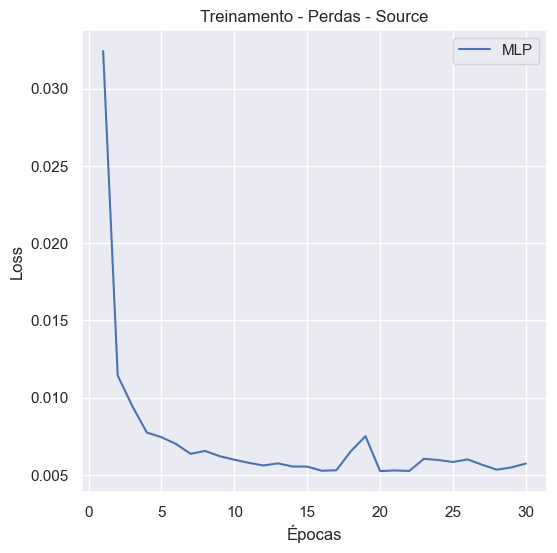

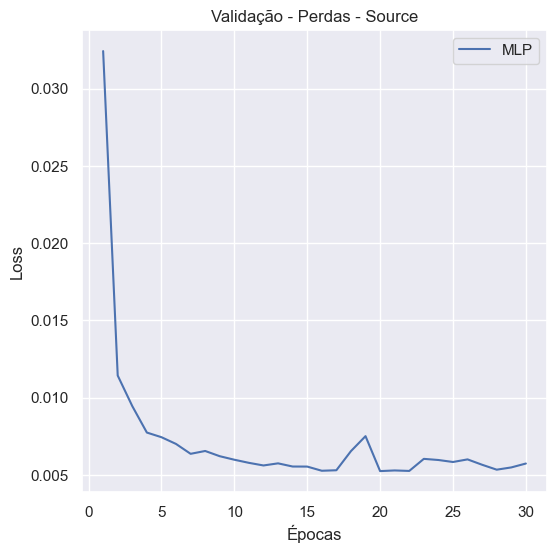

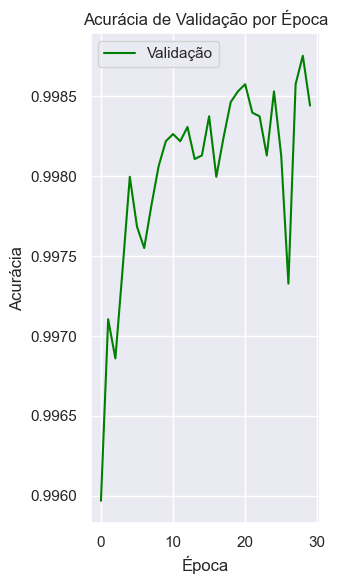

              precision    recall  f1-score   support

         0.0     0.9975    0.9994    0.9984     22492
         1.0     0.9994    0.9975    0.9984     22411

    accuracy                         0.9984     44903
   macro avg     0.9984    0.9984    0.9984     44903
weighted avg     0.9984    0.9984    0.9984     44903



In [52]:
# Instanciando o modelo
input_dim = 41
modelo_MLP = MLP(input_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
all_preds, all_labels = treina_modelo(input_dim, modelo_MLP, loader_train, device)

In [53]:
def valida(target_val, treino):

    # Listas para armazenar o loss e a acurácia
    val_loss, val_losses = [], []
    val_accuracies, val_acc = [], []
    loss_total = 0

    modelo_MLP.eval()
    count = 0

    all_preds, all_labels = [], []

    with torch.no_grad():
       for X_val, y_val in target_val:
           X_val, y_val = X_val.to(device), y_val.to(device).float().view(-1, 1)
           out = modelo_MLP(X_val)

           # Calcula loss (BCE para binário)
           loss = F.binary_cross_entropy(out, y_val)
           val_loss.append(loss)
        
           preds = (out > 0.5).float()
           all_preds.append(preds.cpu())
           all_labels.append(y_val.cpu())
           acc = (preds.view(-1) == y_val.view(-1)).float().mean().item()
           val_accuracies.append(acc)
           count += 1
           if count % 100 == 0:
              losses = sum(val_loss) / len(val_loss)
              acc = sum(val_accuracies) / len(val_accuracies)
              val_losses.append(losses)
              val_acc.append(acc)
              val_loss = []
              val_accuracies = []
            
    all_preds_list = torch.cat(all_preds)
    all_labels_list = torch.cat(all_labels)

    # print(classification_report(all_labels_list, all_preds_list, digits=4, zero_division=0))

    # Matriz de confusão
    matriz2 = confusion_matrix(all_preds_list.detach().numpy().round(), all_labels_list.detach().numpy().round())
    sns.set(rc={"figure.figsize": (6, 6)})
    title = "Matriz de Confusão:" + treino
    sns.heatmap(matriz2, annot=True, annot_kws={'size': 10}, fmt='g').set_title(title)
    plt.show()
    
    TN, FP, FN, TP = matriz2.ravel()
 
    # Cálculo das métricas
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0  # Sensibilidade, Recall
    TNR = TN / (TN + FP) if (TN + FP) != 0 else 0  # Especificidade
    F1 = f1_score(all_labels_list.detach().numpy().round(), all_preds_list.detach().numpy().round())

    return TPR, TNR, F1

Prepara dataset1: (224511, 45)
(179608, 41) (179608, 1)
(44903, 41) (44903, 1)
Treinando com dataset1


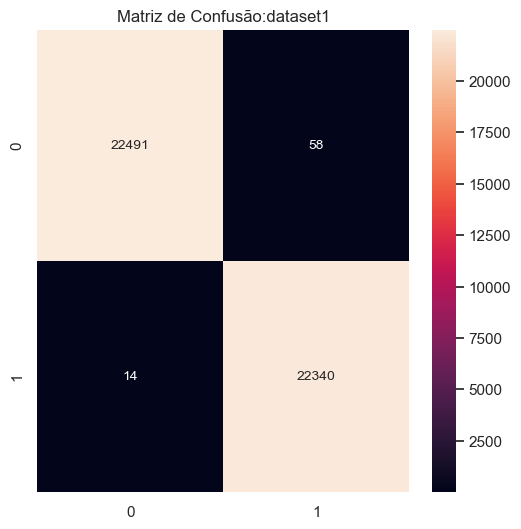

Prepara dataset2: (224512, 45)


C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


(179609, 41) (179609, 1)
(44903, 41) (44903, 1)
Treinando com dataset2


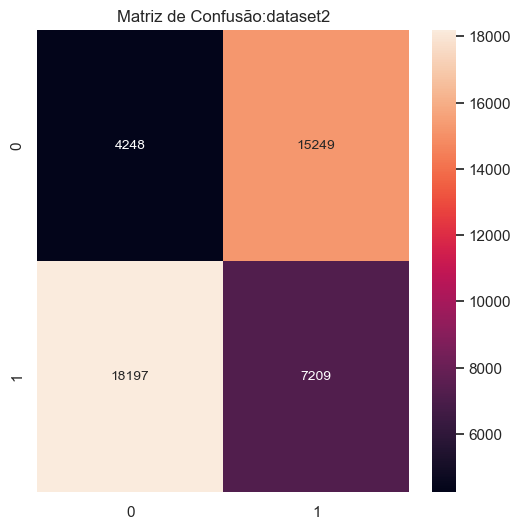

Prepara dataset3: (142152, 45)
(113721, 41) (113721, 1)
(28431, 41) (28431, 1)
Treinando com dataset3


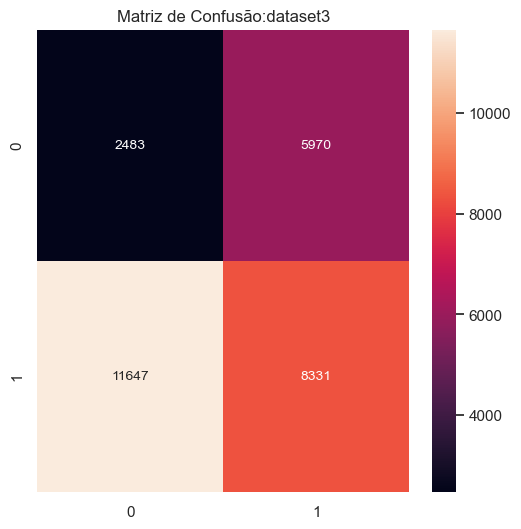

Prepara dataset4: (223976, 45)
(179180, 41) (179180, 1)
(44796, 41) (44796, 1)
Treinando com dataset4


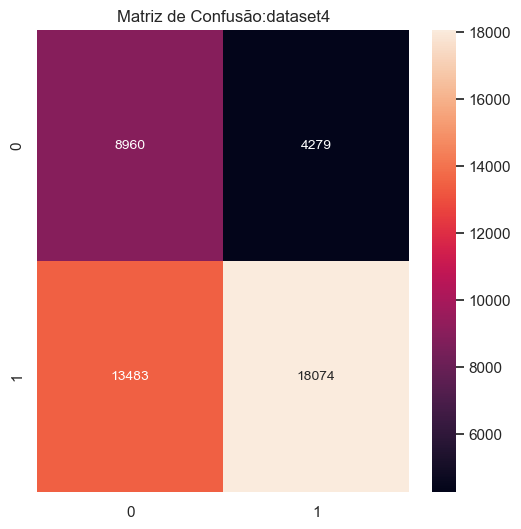

----------------------------------------------
Resumo do treino no Dataset1:
    Dataset       TPR       TNR  F1-Score
0  dataset1  0.999374  0.997428  0.998391
1  dataset2  0.283752  0.217880  0.301228
2  dataset3  0.417009  0.293742  0.486070
3  dataset4  0.572741  0.676788  0.670525
----------------------------------------------


In [54]:
datasets = ["dataset1", "dataset2", "dataset3", "dataset4"]
TPRs = []
TNRs = []
F1s = []
for treino in datasets:
    loader_train, target_val, dataset_train, dataset_train2, class_train, class_val = inicia_datasets(treino)
    print(f"Treinando com {treino}") 
    TPR, TNR, F1 = valida(target_val, treino)
    TPRs.append(TPR)
    TNRs.append(TNR)
    F1s.append(F1)
    
# Criação da tabela
df = pd.DataFrame({
    'Dataset': datasets,
    'TPR': TPRs,
    'TNR': TNRs,
    'F1-Score': F1s
})
print("----------------------------------------------")
print("Resumo do treino no Dataset1:")
print(df)
print("----------------------------------------------")